In [1]:
# importing modules
import numpy as np
import matplotlib.pyplot as plt
import modsim.models.mach_zehnder as mzm
from modsim.signal_gen.arbitrary_generator import SignalGen
import modsim.signal_gen.processing as proc
from tqdm import tqdm
%matplotlib inline

In [2]:
# instantiating signal generation
awg = SignalGen(num_of_samples = 256 * 1024, sampling_time = 25e-5, samples_per_symbol = 4)

In [35]:
# MZM settings
Ein = 1
Vpi_rf = 1
Vpi_bias = Vpi_rf
ER_model = 'Finite'
ER_dB = 20
heaters = True

# RF settings
pulse_fmt = 'NRZ' # 'PAM4' # 'NRZ'
Vpp_rf = 1.0 * Vpi_rf
f_bw = 1000
f_ord = 2

# bias settings
bias_start = 0
bias_end = 4
bias_step = 0.05
bias_dc_array = np.arange(bias_start, bias_end, bias_step) * Vpi_bias
Vpp_dither = 0.04 * Vpi_bias
f_dither = 5 #[Hz]
Vdither = awg.waveform_gen(Vpp_dither/2, f_dither, 0)

# heater driving definitions
Vcc = 5
push_pull = False
pre_sqrt = True

# cross-correlation settings
deg = 2 * 22.5
delay = deg * np.pi / 180
n_cycles = 10
samples_per_cycle = 1 / (awg.Ts * f_dither)
L = n_cycles * int(samples_per_cycle)
#L = None

# pre-allocating array data
N_avg = 1
V_dc = np.zeros((N_avg, bias_dc_array.size)) 
V_ac = [[0] * N_avg] * bias_dc_array.size
V_ac_1 = [[0] * N_avg] * bias_dc_array.size
V_ac_2 = [[0] * N_avg] * bias_dc_array.size
V_dc_1 = np.zeros((N_avg, bias_dc_array.size)) * 1j
V_dc_2 = np.zeros((N_avg, bias_dc_array.size)) * 1j
C_1 = np.zeros((N_avg, bias_dc_array.size)) * 1j
C_2 = np.zeros((N_avg, bias_dc_array.size)) * 1j

# iterating over bias DC array
for k in tqdm(range(bias_dc_array.size)):

    Vbias = bias_dc_array[k] + Vdither
    
    for l in range(N_avg):

        # generating signals
        Vrf = awg.pulse_sequence_gen(pulse_fmt, Vpp_rf / 2, f_bw = f_bw, f_order = f_ord) # [1 kbaud]

        # modulating RF and bias
        if heaters:

            # heater driving definitions
            Vheat = Vbias

            # square-root before applying voltage
            if pre_sqrt:
                V = np.sqrt(Vheat)
            else:
                V = Vheat

            # single heater vs. dual drive push-pull
            if push_pull:                
                Vb_1 = (Vcc - V) / 2
                Vb_2 = V / 2
            else:            
                Vb_1 = V
                Vb_2 = 0

            Vrf_1 = Vrf / 2
            Vrf_2 = -Vrf / 2

            Eout = mzm.lin_with_heaters(Ein, 
                                        Vrf_1,
                                        Vrf_2,
                                        Vb_1,
                                        Vb_2,
                                        Vpi_bias_1 = Vpi_bias,
                                        Vpi_bias_2 = Vpi_bias,
                                        ER_model = ER_model,
                                        ER_dB = ER_dB)
            
        else:
            
            Eout = mzm.lin_push_pull(Ein, 
                                     Vrf, 
                                     Vbias, 
                                     Vpi_rf = Vpi_rf, 
                                     Vpi_bias = Vpi_bias, 
                                     ER_model = ER_model, 
                                     ER_dB = ER_dB)

        # monitor PD out
        Resp = 1
        pd_bw = 100
        pd_ord = 3
        Vout_ = Resp * np.abs(Eout) ** 2
        Vout = np.real(proc.gaussian_filter(Vout_, 0, pd_bw, pd_ord, awg.Ts))

        # ADC downsampling
        down_samp = 100
        Dout = Vout[::down_samp]
        Tn = down_samp * awg.Ts

        # getting DC level
        (V_dc[l,k], V_ac[k][l]) = proc.get_dc_ac(Dout)

        # filtering 1st harmonic
        V_ac_1[k][l] = proc.gaussian_filter(V_ac[k][l], f_dither, 0.125, 4, Tn)
        V_dc_1[l,k] = np.mean(np.abs(V_ac_1[k][l]) ** 2)

        # filtering 2nd harmonic
        V_ac_2[k][l] = proc.gaussian_filter(V_ac[k][l], 2 * f_dither, 0.125, 4, Tn)
        V_dc_2[l,k] = np.mean(np.abs(V_ac_2[k][l]) ** 2)

        # cross-correlation 1st harmonic
        C_1[l,k] = proc.cross_correlation(V_ac_1[k][l], f_dither, Tn, delay = delay, N = L)

        # cross-correlation 2nd harmonic
        C_2[l,k] = proc.cross_correlation(V_ac_2[k][l], 2 * f_dither, Tn, delay = delay, N = L)

# Averaging results
DC_level = np.mean(V_dc, axis = 0)
AC_pwr_1 = np.mean(V_dc_1, axis = 0)
AC_pwr_2 = np.mean(V_dc_2, axis = 0)
XCorr_1 = np.mean(C_1, axis = 0)
XCorr_2 = np.mean(C_2, axis = 0)
        

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.52it/s]


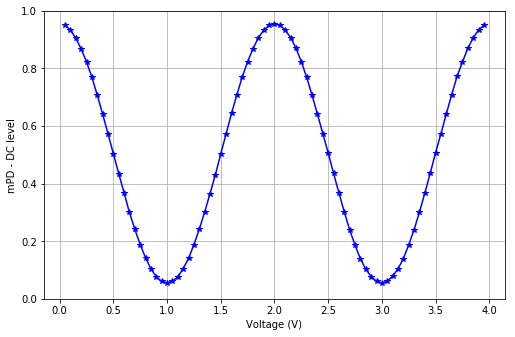

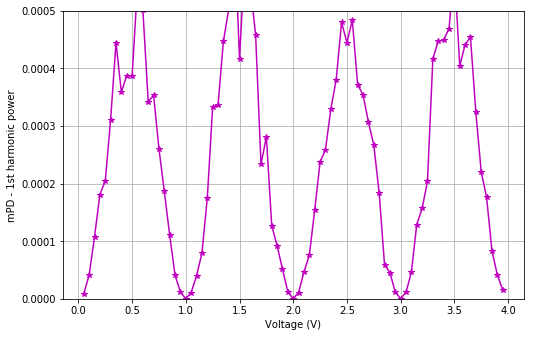

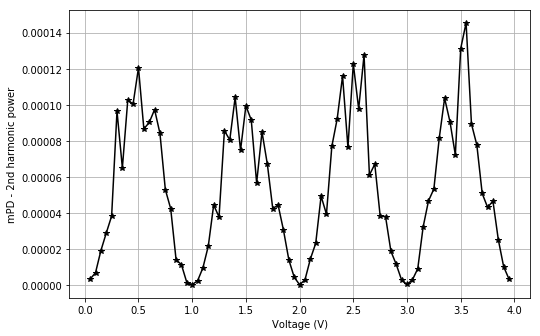

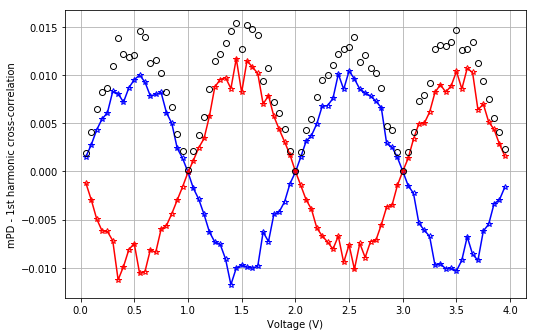

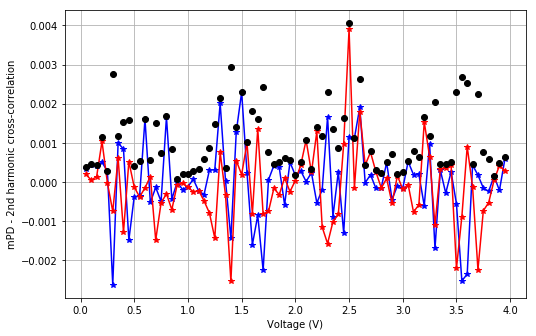

In [36]:
# plotting DC
fig1 = plt.figure(figsize=(8,5))
F1 = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
F1.plot(bias_dc_array, DC_level, 'b*-')
F1.set_xlabel('Voltage (V)')
F1.set_ylabel('mPD - DC level')
#F1.set_xlim([1.5, 2])
F1.set_ylim([0, 1])
F1.grid('on')

# plotting 1st harmonic power
fig2 = plt.figure(figsize=(8,5))
F2 = fig2.add_axes([0.1, 0.1, 0.8, 0.8])
F2.plot(bias_dc_array, AC_pwr_1, 'm*-')
F2.set_xlabel('Voltage (V)')
F2.set_ylabel('mPD - 1st harmonic power')
#F2.set_xlim([1.5, 2])
F2.set_ylim([0, 5e-4])
F2.grid('on')

# plotting 2nd harmonic power
fig3 = plt.figure(figsize=(8,5))
F3 = fig3.add_axes([0.1, 0.1, 0.8, 0.8])
F3.plot(bias_dc_array, AC_pwr_2, 'k*-')
F3.set_xlabel('Voltage (V)')
F3.set_ylabel('mPD - 2nd harmonic power')
#F3.set_ylim([0, 1])
F3.grid('on')

# plotting cross-correlatin 1st harmonic power
fig4 = plt.figure(figsize=(8,5))
F4 = fig4.add_axes([0.1, 0.1, 0.8, 0.8])
F4.plot(bias_dc_array, XCorr_1.real, 'b*-',
        bias_dc_array, XCorr_1.imag, 'r*-',
        bias_dc_array, np.abs(XCorr_1), 'ko', fillstyle = 'none')
F4.set_xlabel('Voltage (V)')
F4.set_ylabel('mPD - 1st harmonic cross-correlation')
#F4.set_xlim([1.5, 2])
#F4.set_ylim([-2e-2, 2e-2])
F4.grid('on')

# plotting cross-correlatin 2nd harmonic power
fig5 = plt.figure(figsize=(8,5))
F5 = fig5.add_axes([0.1, 0.1, 0.8, 0.8])
F5.plot(bias_dc_array, XCorr_2.real, 'b*-',
        bias_dc_array, XCorr_2.imag, 'r*-',
        bias_dc_array, np.abs(XCorr_2), 'ko')
F5.set_xlabel('Voltage (V)')
F5.set_ylabel('mPD - 2nd harmonic cross-correlation')
#F5.set_ylim([0, 1])
F5.grid('on')

# plotting cross-correlation 1st/2nd harmonic ratio
fig6 = plt.figure(figsize=(8,5))
F6 = fig6.add_axes([0.1, 0.1, 0.8, 0.8])
F6.plot(bias_dc_array,np.abs(XCorr_2) / np.abs(XCorr_1), 'm*-')
F6.set_xlabel('Voltage (V)')
F6.set_ylabel('mPD - 1st/2nd harmonic cross-correlation ratio')
#F6.set_ylim([0, 1])
F6.grid('on')

ValueError: x and y must have same first dimension, but have shapes (2622,) and (1, 2622)

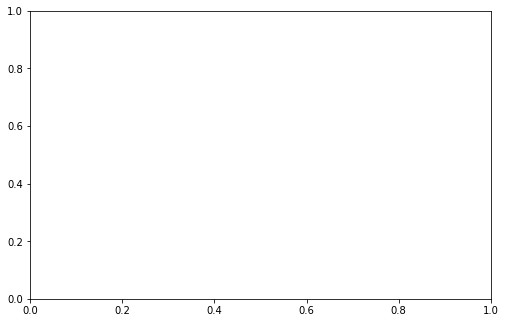

In [37]:
idx = 5

time = awg.time[::down_samp]
frequency = awg.frequency[::down_samp]

# plotting mPD signals
fig6 = plt.figure(figsize=(8,5))
F6 = fig6.add_axes([0.1, 0.1, 0.8, 0.8])
F6.plot(time, V_ac[idx], 'b-', 
        time, V_ac_1[idx], 'm-', 
        time, V_ac_2[idx], 'k-')
F6.set_xlabel('Time (s)')
F6.set_ylabel('Voltage (V)')
F6.set_xlim([0, 2])
#F6.set_ylim([-60,60])
F6.grid('on')

V_ac_f = np.fft.fftshift(np.fft.fft(V_ac[idx]))
V_ac_1_f = np.fft.fftshift(np.fft.fft(V_ac_1[idx]))
V_ac_2_f = np.fft.fftshift(np.fft.fft(V_ac_2[idx]))

# plotting spectrum [dither zoom]
fig7 = plt.figure(figsize=(8,5))
F7 = fig7.add_axes([0.1, 0.1, 0.8, 0.8])
F7.plot(frequency, 10 * np.log10(abs(V_ac_f)), 'b-', 
        frequency, 10 * np.log10(abs(V_ac_1_f)), 'm-', 
        frequency, 10 * np.log10(abs(V_ac_2_f)), 'k-')
F7.set_xlabel('Frequency (Hz)')
F7.set_ylabel('Magnitude (dB)')
F7.set_xlim([1.5,2.5])
F7.set_ylim([-60,60])
F7.grid('on')

# plotting spectrum [full range]
fig8 = plt.figure(figsize=(8,5))
F8 = fig8.add_axes([0.1, 0.1, 0.8, 0.8])
F8.plot(frequency, 10 * np.log10(abs(V_ac_f)), 'b-', 
        frequency, 10 * np.log10(abs(V_ac_1_f)), 'm-', 
        frequency, 10 * np.log10(abs(V_ac_2_f)), 'k-')
F8.set_xlabel('Frequency (Hz)')
F8.set_ylabel('Magnitude (dB)')
F8.set_xlim([-100,100])
F8.set_ylim([-60,60])
F8.grid('on')

In [ ]:
# Plotting RF
fig9 = plt.figure(figsize=(8,5))
F9 = fig9.add_axes([0.1, 0.1, 0.8, 0.8])
F9.plot(awg.time, Vrf, 'k*-')
F9.set_xlabel('Time (s)')
F9.set_ylabel('Voltage (V)')
F9.set_xlim([0, 0.05])
#F9.set_ylim([-60,60])
F9.grid('on')

In [ ]:
# saving results
import os

# folder name
save_folder = '../../mod_sim_results/MZM_linear_ER_20dB/rf_amp_2pt0_Vpi/'

# creating folders if they do not exist
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
    
# saving figures
fig1.savefig(save_folder + 'nrz_2Vpi_mpd_dc.png')
fig2.savefig(save_folder + 'nrz_2Vpi_mpd_1st_hm_pwr.png')
fig4.savefig(save_folder + 'nrz_2Vpi_mpd_1st_hm_xcorr_' + str(int(deg)) + 'deg.png')

In [31]:
10*np.log10(DC_level[1:].max()/DC_level[1:].min())

6.665435336533397